### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import cal_mape

from utilities import cal_score, convert_types, create_dt_feats

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [2]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

cols_num_add = ['land_per_building_area']
cols_cat_add = ['encoded_latlon']
cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [3]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['land_per_building_area'] = df['land_area'] / df['building_area']
 
    #cols_feats = cols_num + cols_cat + cols_feats_add
    
    # fix town and city
    df['town'] = df['city'].astype('str')+'-'+df['town'].astype('str')
    df['village'] = df['town'].astype('str')+'-'+df['village'].astype('str')
    
    return df  #, cols_feats

In [4]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding
from feature_engineering import Imputation

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        #self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
        # imputer
        self.imputer = Imputation()
        
    def fit_transform(self, df):
        df = df.copy()
    
        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
        encoded1 = encoded1.rename(columns={'encoded_'+col: col for col in self.cols_cat})
        df.loc[:,self.cols_cat] = encoded1[self.cols_cat]

        imputed = self.imputer.fit_transform(df, cols=self.cols_num)
        df.loc[:,self.cols_num] = imputed[self.cols_num]
        
        return df

#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
#        self.cat_astyper.fit_transform(df, self.cols_cat)    
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
        
        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
        encoded1 = encoded1.rename(columns={'encoded_'+col: col for col in self.cols_cat})
        df.loc[:,self.cols_cat] = encoded1[self.cols_cat]

        imputed = self.imputer.transform(df, cols=self.cols_num)
        df.loc[:,self.cols_num] = imputed[self.cols_num]
        
        return df

#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
#        self.cat_astyper.transform(df)
#        return pd.concat([df, encoded1, encoded2], axis=1)


In [5]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [7]:
df = pd.read_csv('dataset/train.csv', dtype=object)
df.head(5)

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_500,XIV_index_500,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,58,1,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,28,1,115,1,15872,1,32221,1,40.07357348973039,3321452.0
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,78,1,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,20,1,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,18,1,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696


### Preprocessing

In [8]:
df = pre_processing(df, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### Construct feats cols

In [9]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on feature shuffle results (exp-l04-per-area)

In [10]:
# PARS #
N_feats_rm = 75
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

print('N num feats (before):', len(cols_num))
cols_num = list(set(cols_num) - set(feats_rm))
print('N num feats (after):', len(cols_num))
print(cols_num)

print('N cat feats (before):', len(cols_cat))
cols_cat = list(set(cols_cat) - set(feats_rm))
print('N cat feats (after):', len(cols_cat))
print(cols_cat)

check1 = set(cols_feats) - set(cols_cat) - set(cols_num)
assert len(check1)==0, 'cols_feats - cols_cat - cols_num: {}'.format(check1)
check2 = (set(cols_cat) | set(cols_num)) - set(cols_feats)
assert len(check2)==0, 'cols_cat + cols_num - cols_feats: {}'.format(check2)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Grid search

In [11]:
params_fix = {'n_jobs': -1}

#params_gsearch = {
#    'max_depth': [None, 8, 16, 20, 24],
#    'max_features': [None, 'log2', 0.5, 0.8],
#    'min_samples_split': [2, 10, 20, 50]
#}
#N_iter = 5 * 4 * 4


params_gsearch = {
    'n_estimators': [10, 100, 500, 1000, 2000, 5000, 10000, 20000]
}
N_iter = 8

N_fold = 3
score_low_bound = 0 # if score smaller than this, skip the param set

#### Round 1

In [12]:
# Round 1
rand_params_set = []
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [13]:
t0 = time.time()
gsearch = {}

### stratified
id_check = df['building_id'].copy()
df_tmp = df[['building_id','total_price']].copy()
df_tmp = df_tmp.sort_values(by='total_price').reset_index(drop=True)
df_tmp['total_price_level'] = df_tmp['total_price'].index // (df_tmp.shape[0] // 6 )
df = pd.merge(df, df_tmp.drop('total_price', axis=1), on='building_id', how='left')
print(df['total_price_level'].value_counts())
print(df.index)
assert (id_check == df['building_id']).all(), 'building_id err'
###

#folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
folds = StratifiedKFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df, df['total_price_level'])): # stratified-kfold
#for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train).copy()
    df_val = feat_eng.transform(df_val).copy()
    
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        params = params_fix.copy()
        params.update(params_rand)
        
        model = RandomForestRegressor(**params)
        model.fit(df_train[cols_feats], df_train[col_target])

        y_pred = model.predict(df_val[cols_feats])
        mse = mean_squared_error(df_val[col_target], y_pred)
        mae = mean_absolute_error(df_val[col_target], y_pred)
        mape = cal_mape(df_val[col_target], y_pred)
        
        y_pred_final = post_processing(y_pred, df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape))

        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append('nothing')
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
# aggregate, sort gsearch results
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)
t1 = time.time()

==== Fold 1 ====
params: {'n_jobs': -1, 'n_estimators': 500}
score, mse, mae, mape: 4830.81825, 0.06753, 0.16529, 0.01248.
params: {'n_jobs': -1, 'n_estimators': 5000}
score, mse, mae, mape: 4840.81839, 0.06746, 0.16512, 0.01247.
params: {'n_jobs': -1, 'n_estimators': 10000}
score, mse, mae, mape: 4826.81849, 0.06739, 0.16508, 0.01246.
params: {'n_jobs': -1, 'n_estimators': 1000}
score, mse, mae, mape: 4824.81835, 0.06742, 0.16531, 0.01248.
params: {'n_jobs': -1, 'n_estimators': 10}
score, mse, mae, mape: 4511.80516, 0.07531, 0.17762, 0.01340.
params: {'n_jobs': -1, 'n_estimators': 2000}
score, mse, mae, mape: 4831.81822, 0.06754, 0.16523, 0.01247.
params: {'n_jobs': -1, 'n_estimators': 20000}
score, mse, mae, mape: 4830.81853, 0.06738, 0.16507, 0.01246.
params: {'n_jobs': -1, 'n_estimators': 100}
score, mse, mae, mape: 4780.81621, 0.06871, 0.16657, 0.01258.
==== Fold 2 ====
params: {'n_jobs': -1, 'n_estimators': 500}
score, mse, mae, mape: 4836.82396, 0.06547, 0.16416, 0.01237.
params

In [14]:
print('Total computing time:', t1-t0)

Total computing time: 43303.15902709961


In [15]:
for row in gsearch_results:
    print(*[x for i, x in enumerate(row) if i != 5])

(('n_jobs', -1), ('n_estimators', 5000)) 4832.486268829904 0.06757912064872906 0.16545538839521134 0.012482092841694102 [4840.818388928506, 4863.824794892606, 4792.815622668599] [0.06745986986344224, 0.06510733101213627, 0.0701701610706087] [0.16511800174234867, 0.1637388620395527, 0.16750930140373266] [0.012465604798426138, 0.012332767038040211, 0.012647906688615956]
(('n_jobs', -1), ('n_estimators', 2000)) 4825.486141399552 0.06762394465107273 0.16552630475372518 0.012487606209893962 [4831.818217824603, 4850.824682335902, 4793.815524038149] [0.06753604830234233, 0.06516011153532805, 0.0701756741155478] [0.16523135244536083, 0.16381620369509178, 0.16753135812072292] [0.01247470793276424, 0.012338345968453967, 0.012649764728463683]
(('n_jobs', -1), ('n_estimators', 20000)) 4824.153006698362 0.06752984412774199 0.16541974641584448 0.01247937268419678 [4830.818531720081, 4845.824818947847, 4795.815669427161] [0.06737660158650972, 0.06506386547419878, 0.07014906532251745] [0.1650683224611

In [16]:
gsearch_results

[[(('n_jobs', -1), ('n_estimators', 5000)),
  4832.486268829904,
  0.06757912064872906,
  0.16545538839521134,
  0.012482092841694102,
  ['nothing', 'nothing', 'nothing'],
  [4840.818388928506, 4863.824794892606, 4792.815622668599],
  [0.06745986986344224, 0.06510733101213627, 0.0701701610706087],
  [0.16511800174234867, 0.1637388620395527, 0.16750930140373266],
  [0.012465604798426138, 0.012332767038040211, 0.012647906688615956]],
 [(('n_jobs', -1), ('n_estimators', 2000)),
  4825.486141399552,
  0.06762394465107273,
  0.16552630475372518,
  0.012487606209893962,
  ['nothing', 'nothing', 'nothing'],
  [4831.818217824603, 4850.824682335902, 4793.815524038149],
  [0.06753604830234233, 0.06516011153532805, 0.0701756741155478],
  [0.16523135244536083, 0.16381620369509178, 0.16753135812072292],
  [0.01247470793276424, 0.012338345968453967, 0.012649764728463683]],
 [(('n_jobs', -1), ('n_estimators', 20000)),
  4824.153006698362,
  0.06752984412774199,
  0.16541974641584448,
  0.012479372684

In [17]:
#aaa= {}
#for g in gsearch_results:
#    nrm = g[0][11][1]
#    score = g[1]
#    if nrm not in aaa:
#        aaa[nrm] = score
#    elif score > aaa[nrm]:
#            aaa[nrm] = score
#print(aaa)
#bbb = np.array(sorted(aaa.items(), key= lambda x: x[0]))
#plt.plot(bbb[:,0], bbb[:,1], '-o')

In [18]:
metrics = ['score', 'mse', 'mae', 'mape']

In [21]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
#    result['best_iteration'] = np.mean([m.best_iteration for m in row[5]])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())+metrics] # +['best_iteration']
display(df_gsearch_results)

,n_estimators,score,mse,mae,mape
0,5000,4832.486269,0.067579,0.165455,0.012482
1,2000,4825.486141,0.067624,0.165526,0.012488
2,20000,4824.153007,0.067530,0.165420,0.012479
3,10000,4824.152975,0.067549,0.165442,0.012481
4,500,4816.819123,0.067801,0.165774,0.012507
5,1000,4815.819314,0.067747,0.165681,0.012499
6,100,4793.151029,0.068646,0.166975,0.012597
7,10,4509.139531,0.075669,0.177919,0.013412


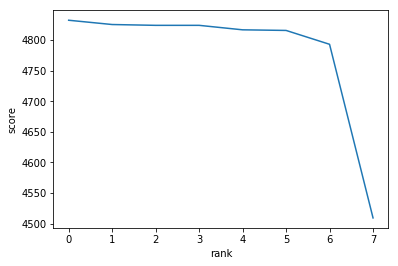

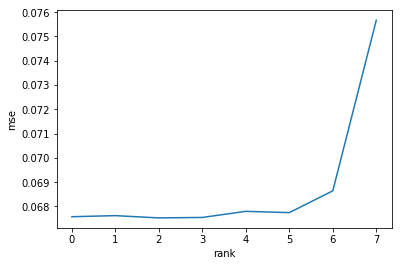

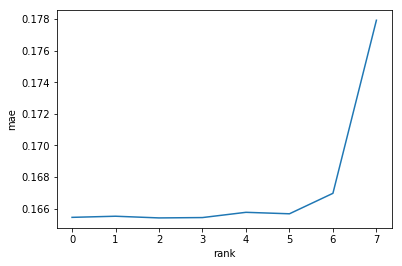

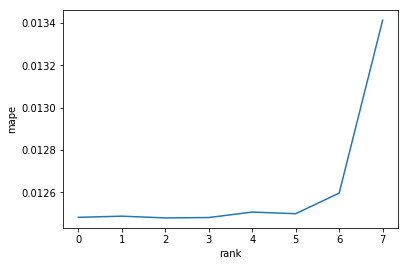

In [22]:
for name in metrics:
    plt.plot(df_gsearch_results[name])
    plt.xlabel('rank'); plt.ylabel(name); plt.show()

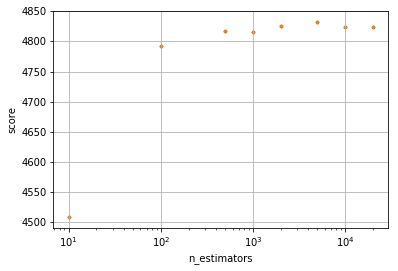

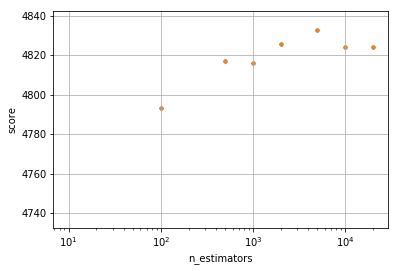

In [51]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=7)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=7)
    plt.xlabel(p); plt.ylabel('score'); plt.xscale('log'); plt.grid(); plt.show()
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=10)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=10)
    plt.xlabel(p); plt.ylabel('score'); plt.xscale('log'); 
    plt.ylim(df_gsearch_results['score'][:10].max()-100, df_gsearch_results['score'][:10].max()+10); plt.grid(); plt.show()

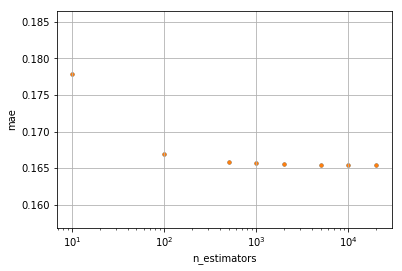

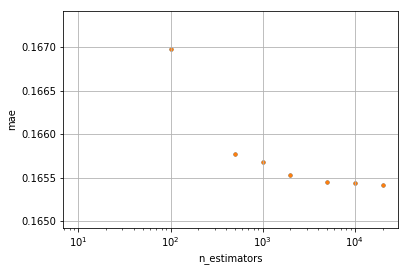

In [48]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=10)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=10)
    plt.xlabel(p); plt.ylabel('mae'); plt.xscale('log'); plt.grid(); plt.show()
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=10)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=10)
    plt.xlabel(p); plt.ylabel('mae'); plt.xscale('log'); 
    plt.ylim(df_gsearch_results['mae'].min()-0.0005, df_gsearch_results['mae'].min()+0.002); plt.grid(); plt.show()

In [29]:
df_gsearch_results.columns

Index(['n_estimators', 'score', 'mse', 'mae', 'mape'], dtype='object')

#best iteration
for c in df_gsearch_results.columns:
    if c != 'best_iteration':
        plt.scatter(df_gsearch_results['best_iteration'], df_gsearch_results[c])
        plt.ylabel(c)
    else:
        plt.hist(df_gsearch_results['best_iteration'], bins=30)
        plt.ylabel('N')        
    plt.xlabel('best_iteration')
    plt.show()

### Compute correlation

#### correlation for num feats

[['building_area' 0.004409716998422031 0.004409716998422031]
 ['XIV_50' 0.028219079605206927 0.028219079605206927]
 ['land_area' -0.04240772536374149 0.04240772536374149]
 ['txn_floor' -0.043790374542577164 0.043790374542577164]
 ['XIV_100' 0.04581863693587386 0.04581863693587386]
 ['land_per_building_area' -0.07214458078836318 0.07214458078836318]
 ['XIV_250' 0.07511520319308908 0.07511520319308908]
 ['parking_area' 0.07946155517973283 0.07946155517973283]
 ['XIV_MIN' -0.08731459849477233 0.08731459849477233]
 ['building_complete_dt' -0.0880369935695401 0.0880369935695401]
 ['IV_100' 0.08901320517895964 0.08901320517895964]
 ['XIII_50' 0.09176742868072367 0.09176742868072367]
 ['XIV_500' 0.09773694981373081 0.09773694981373081]
 ['txn_dt' 0.10211860321027197 0.10211860321027197]
 ['X_50' 0.11403570756235858 0.11403570756235858]
 ['XIV_1000' 0.1148232436078084 0.1148232436078084]
 ['VIII_10' 0.125024222989481 0.125024222989481]
 ['N_10000' 0.12872651499964394 0.12872651499964394]
 ['XI

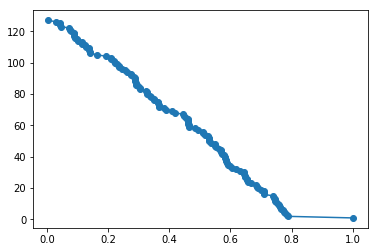

In [31]:
corr = pd.DataFrame({'corr': df[cols_num+['target']].corr()['target']})
corr['abs_corr'] = np.abs(corr['corr'])
corr = corr.sort_values(by='abs_corr')
print(corr.reset_index().values)
corr['cum_count'] = range(corr.shape[0], 0, -1)
plt.plot(corr['abs_corr'], corr['cum_count'], '-o')

# Other parameter results

(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.5), ('min_samples_split', 2)) 4894.494214273407 0.06265746939525367 0.16028405906807822 0.012085187770723897 [4895.830016675878, 4885.828324269542, 4901.824301874801] [0.06024280947473378, 0.064221472360651, 0.06350812635037621] [0.15843030636390684, 0.16058703706897995, 0.16183483377134783] [0.011956074029166317, 0.012095821802066047, 0.012203667480939324]  
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.5), ('min_samples_split', 2)) 4876.160085271735 0.06308521423338094 0.16073573369304103 0.012120703853966195 [4890.829930419136, 4867.826984194412, 4869.823341201656] [0.060108032404545944, 0.06504224602957091, 0.06410536426602595] [0.15858820401279888, 0.1611535938751923, 0.1624654031911319] [0.011967245019534735, 0.012141935878537657, 0.01225293066382619]  
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.8), ('min_samples_split', 2)) 4859.821791323055 0.06670492039929045 0.1634845294652394 0.012339044318081147 [4865.824723560141, 4858.821506113914, 4854.819144295109] [0.06381348866412308, 0.06913113622410681, 0.06717013630964147] [0.16170115433994123, 0.1639093448019447, 0.16484308925383226] [0.0122140309674413, 0.012362699295706351, 0.012440402691095791]  
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.8), ('min_samples_split', 2)) 4851.488183432914 0.06676639751322253 0.1637180453188293 0.012356681138586475 [4858.824306583111, 4855.8211531809075, 4839.819090534726] [0.06392131646253335, 0.06922062617771226, 0.06715724989942198] [0.1618491840103487, 0.1641379531125099, 0.16516699883362929] [0.01222614553554275, 0.012380081454909172, 0.012463816425307498]  
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', None), ('min_samples_split', 2)) 4815.151885689237 0.06884730413310751 0.16569492134834576 0.012506830216372307 [4806.821621313692, 4825.817423828317, 4812.816611925702] [0.06590365906941706, 0.0717768667308858, 0.06886138659901965] [0.16405559348284468, 0.1663457299430262, 0.1666834406191664] [0.012390755085657415, 0.012551006671834413, 0.0125787288916251]  
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.5), ('min_samples_split', 2)) 4808.492070843775 0.06344013535346599 0.1620625637309551 0.012218930105771832 [4802.82789529089, 4808.826069461986, 4813.822247778448] [0.06094251415813592, 0.0650746248372235, 0.06430326706503857] [0.16026314862558702, 0.16233840620833073, 0.1635861363589476] [0.012092863798400163, 0.012228670571349895, 0.01233525594756544]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', None), ('min_samples_split', 2)) 4801.818132550052 0.06899712244060341 0.16603551984056947 0.012532099815613283 [4793.820954312809, 4818.816641960497, 4792.81680137685] [0.06613146477441396, 0.07221384712555973, 0.06864605542183655] [0.1645388433374626, 0.1666781135471317, 0.1668896026371141] [0.012427616431827555, 0.01257748745480008, 0.012591195560212215]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.8), ('min_samples_split', 2)) 4793.820150837365 0.06713520787841128 0.16500052263848983 0.01245178364007792 [4777.8232407392, 4808.81942886031, 4794.817782912585] [0.06411104212726428, 0.0697903318376494, 0.06750424967032016] [0.1630876433014977, 0.16551479900968635, 0.1663991256042854] [0.01231631758237285, 0.012483297678538964, 0.012555735659321944]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', None), ('min_samples_split', 2)) 4736.4833366374 0.06938223264432701 0.16738381714674702 0.012632339006567989 [4716.820022098716, 4752.8148244235645, 4739.815163389919] [0.06619312255266271, 0.07286022058533198, 0.06909335479498632] [0.16569917356582783, 0.16810325740314216, 0.16834902047127107] [0.012512200114018934, 0.012683969831774226, 0.012700847073910802]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.5), ('min_samples_split', 10)) 4734.82304341886 0.06455264580748156 0.16448116144294805 0.012397550161997497 [4735.825259395929, 4740.824279223627, 4727.819591637025] [0.062277589759409495, 0.06568966427436472, 0.06569068338867047] [0.16292668494704704, 0.164295381106129, 0.1662214182756681] [0.012290443200840684, 0.012371743178934332, 0.012530464106217476]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.5), ('min_samples_split', 10)) 4724.156427600588 0.064468543707852 0.1645050840827522 0.012399064920990967 [4727.825477725621, 4726.82407891989, 4717.819726156255] [0.06205944820205, 0.06584466616779285, 0.06550151675371316] [0.16279058444300926, 0.16451460764003611, 0.16621006016521114] [0.01227900795521076, 0.01238903980840477, 0.012529146999357374]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.8), ('min_samples_split', 10)) 4722.151127396878 0.06823530162620285 0.16729815421961755 0.012621498860495755 [4720.820549328047, 4733.817436401448, 4711.815396461138] [0.06544278373178498, 0.07057652185459587, 0.06868659929222772] [0.16560218181465408, 0.1676566945772915, 0.16863558626690708] [0.012503021085507481, 0.012640742447674918, 0.012720733048304863]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.8), ('min_samples_split', 10)) 4718.150877554969 0.06845432704036207 0.16739366375830764 0.012630208438540425 [4719.820214900478, 4736.817445310021, 4697.814972454407] [0.06566954166640657, 0.0706835542840868, 0.06900988517059281] [0.16581632737156315, 0.1675039643783978, 0.1688606995249619] [0.012521561790061852, 0.012630164047400678, 0.012738899478158745]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', None), ('min_samples_split', 10)) 4693.147726768011 0.0705869687660237 0.16946810066867338 0.012787160090912434 [4681.817493006387, 4704.813257468176, 4692.81242982947] [0.0676130242391015, 0.07337530134404512, 0.0707725807149245] [0.1679037687171008, 0.16991930041558623, 0.17058123287333318] [0.012676401888544348, 0.012817211128381752, 0.012867867255811205]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.5), ('min_samples_split', 10)) 4679.488661189756 0.06481794379830781 0.1654252965698392 0.012468973713355654 [4679.824731783258, 4677.822296339893, 4680.818955446118] [0.062176228812749215, 0.06658169021700029, 0.06569591236517391] [0.16362747725631527, 0.16564349623708718, 0.16700491621611516] [0.0123414191446277, 0.01247700779281269, 0.01258849420262657]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', None), ('min_samples_split', 10)) 4673.814261743043 0.07058144099502774 0.1696256209148542 0.012798454262698433 [4663.81725059525, 4691.812958811786, 4665.812575822094] [0.0676415690216829, 0.073512581072221, 0.07059017289117929] [0.16817655027124515, 0.16996613861265294, 0.17073417386066453] [0.012696116736766318, 0.012820655031254175, 0.012878591020074803]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.8), ('min_samples_split', 10)) 4660.483206534533 0.06863316759006416 0.16846563967922148 0.012709333496440581 [4649.819091882276, 4684.816422227974, 4646.814105493347] [0.06597774086892225, 0.07082305772771048, 0.06909870417355973] [0.1669724574368845, 0.16851818360796492, 0.16990627799281513] [0.012606540401985796, 0.012705521797790184, 0.012815938289545767]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', None), ('min_samples_split', 10)) 4619.146527432433 0.07089189233669772 0.17073271148129965 0.012880498175981683 [4598.816067186805, 4636.812278112417, 4621.811236998078] [0.0680330455238713, 0.07354786507844083, 0.07109476640778106] [0.16930663139664093, 0.1709660242493251, 0.1719254787979329] [0.012780348894002307, 0.012894407387682848, 0.012966738246259891]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.5), ('min_samples_split', 20)) 4547.817115884131 0.06730053278329712 0.16998752414931748 0.012808697883645236 [4553.819760754908, 4553.817707057688, 4535.813879839797] [0.06462429680584478, 0.06897539113785273, 0.06830191040619384] [0.16830038819423185, 0.1698525745458452, 0.1718096097078753] [0.012689380781344078, 0.01279026289976823, 0.0129464499698234]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.5), ('min_samples_split', 2)) 4544.486051147253 0.06553323466073922 0.16790042971120836 0.01265759303894235 [4537.822041114304, 4553.820208806315, 4541.815903521141] [0.06286467811894535, 0.06711239650614347, 0.06662262935712883] [0.16610736040262625, 0.16801126647539022, 0.1695826622556086] [0.012529759182441924, 0.012655605344022764, 0.012787414590362358]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.5), ('min_samples_split', 20)) 4538.483689883499 0.0674229621036436 0.17003495478387812 0.012812616853237068 [4543.819490733324, 4535.818154927193, 4535.813423989981] [0.06487074794528541, 0.06867924175028599, 0.06871889661535938] [0.16854334488076173, 0.16964264736100304, 0.1719188721098696] [0.012708681804115668, 0.012773782380484367, 0.01295538637511117]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.8), ('min_samples_split', 20)) 4536.145298349221 0.07097650906333437 0.17281032507204439 0.013033058312526264 [4537.814717462754, 4540.812000713763, 4529.809176871146] [0.06814529401433932, 0.07308203260461793, 0.07170220057104588] [0.17124904560002258, 0.17277473083181852, 0.17440719878429198] [0.012924227448482815, 0.01302268797464458, 0.0131522595144514]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.8), ('min_samples_split', 20)) 4527.478569967554 0.07102580663761072 0.17290140178502936 0.01303948953711312 [4525.81446019134, 4548.811682810341, 4507.80956690098] [0.06825613009272559, 0.07342231224703256, 0.07139897757307401] [0.17150359497849357, 0.17286098940878264, 0.1743396209678119] [0.01294281078551875, 0.01302972548549196, 0.013145932340328646]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.8), ('min_samples_split', 2)) 4513.480387687672 0.06939254512540786 0.1712737717516322 0.012920533847512418 [4505.816283969034, 4524.813554210526, 4509.811324883456] [0.06651613240109781, 0.0718192397182698, 0.069842263256856] [0.16971972663169604, 0.17152819230539446, 0.17257339631780613] [0.012812281760896148, 0.012932118535781072, 0.013017201245860035]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.5), ('min_samples_split', 20)) 4512.816853738083 0.0672568162679577 0.1705648195996385 0.012849915202618467 [4512.819112071632, 4518.818192427893, 4506.813256714724] [0.06485257764811009, 0.06841921725176564, 0.06849865390399736] [0.1689677679538338, 0.1701963753712075, 0.17253031547387424] [0.01273858064376309, 0.012811570913411688, 0.01299959405068062]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', None), ('min_samples_split', 20)) 4502.808697398165 0.07319961055954115 0.17504366349381825 0.013201604395971003 [4482.811327138111, 4524.807798253931, 4500.806966802455] [0.07045996428677455, 0.07596900323504811, 0.07316986415680077] [0.1738097847384919, 0.17519835647925514, 0.17612284926370775] [0.013115739255780832, 0.013209551023594453, 0.013279522908537723]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', None), ('min_samples_split', 20)) 4502.475286029516 0.07319770293014116 0.17511385259986975 0.01320628503598572 [4492.811408365316, 4511.807340542847, 4502.807109180384] [0.07035052301215398, 0.07620235844600987, 0.07304022733225961] [0.1738223893588512, 0.17534454038830355, 0.17617462805245443] [0.013115872146113696, 0.013221328318028963, 0.013281654643814499]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.8), ('min_samples_split', 20)) 4494.145016712325 0.07091190496111978 0.1734519177448299 0.013079138270370117 [4510.814020656738, 4500.811842624629, 4470.809186855609] [0.06825269992441067, 0.07299245858579255, 0.0714905563731561] [0.17213076508901642, 0.17329180898296712, 0.17493317916250617] [0.012989453100345083, 0.013058592996053206, 0.01318936871471206]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.5), ('min_samples_split', 10)) 4475.816875245216 0.06671676598297772 0.17034077379992793 0.012837030240526251 [4461.819089000489, 4483.818046699343, 4481.813490035815] [0.06432699092580749, 0.06791091322182659, 0.06791239380129908] [0.16891952606131747, 0.17005472685399506, 0.1720480684844712] [0.012737381051417475, 0.012805810717959719, 0.012967898952201561]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', None), ('min_samples_split', 20)) 4465.47490122206 0.07315996934835246 0.17579495376064389 0.013255575323577457 [4450.810572452055, 4479.8074240029855, 4465.80670721114] [0.07058398120601371, 0.07581061302874284, 0.07308531381030085] [0.17472079943308244, 0.17585686749103951, 0.17680719435780964] [0.013182449072962921, 0.013257176855642198, 0.013327100042127251]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', None), ('min_samples_split', 2)) 4463.143303326953 0.07175546667994602 0.1737721264168427 0.013108053716606642 [4432.812743200847, 4489.808971552751, 4466.808195227261] [0.06887971077868187, 0.07465117171599503, 0.07173551754516118] [0.17250348446585742, 0.17401328617525283, 0.17479960860941784] [0.013017861766390129, 0.013124182815410649, 0.013182116568019145]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.8), ('min_samples_split', 10)) 4448.144696730095 0.07052877192105024 0.1734893765491119 0.013083745452947063 [4442.813799695802, 4461.811133098365, 4439.80915739612] [0.06784110689883259, 0.07284984572754014, 0.07089536313677802] [0.172118400498201, 0.17358304281275042, 0.1747666863363843] [0.012989155882145243, 0.013083897521558389, 0.013178182955137552]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', None), ('min_samples_split', 10)) 4404.474208299493 0.07295817839262748 0.17616729661847694 0.01328435330621721 [4388.810417384603, 4425.806352160572, 4398.805855353303] [0.06997090353669903, 0.07589718527735526, 0.07300644636382819] [0.1748894977294898, 0.17640597232212457, 0.17720641980381646] [0.013193010427752271, 0.013300776267892023, 0.013359273223007334]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.5), ('min_samples_split', 20)) 4351.479570994291 0.06878129308056695 0.1742375031317441 0.013125775158272535 [4354.815100883041, 4365.814550223583, 4333.809061876246] [0.06646216622665437, 0.06963052559427846, 0.07025118742076801] [0.17292233603179716, 0.17352615637001045, 0.1762640169934247] [0.013033413530025172, 0.01306241248748147, 0.013281499457310962]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.8), ('min_samples_split', 20)) 4336.473808712922 0.07271244463036687 0.17754325006138374 0.013384927583131543 [4344.809189944347, 4350.807120802968, 4313.80511539145] [0.07019486131313943, 0.07496519562494743, 0.07297727695301376] [0.17633430892409838, 0.177440087997769, 0.1788553532622838] [0.013304208960357188, 0.013370034009898819, 0.013480539779138623]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', None), ('min_samples_split', 20)) 4285.1370018912685 0.07494536474243878 0.1801200353457462 0.013576816352380469 [4265.806138905946, 4312.803067077897, 4276.801799689964] [0.07218293411233906, 0.0775840792083933, 0.07506908090658396] [0.17911276530476486, 0.18002995353724693, 0.18121738719522681] [0.013507147780405961, 0.013567095042990997, 0.013656206233744445]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.5), ('min_samples_split', 50)) 4194.803816565755 0.07456831545600907 0.1827552031143452 0.0137589512659011 [4190.806240227417, 4190.804847272697, 4202.800362197153] [0.07191434942484044, 0.0759623687673295, 0.07582822817585731] [0.1813969502388945, 0.1820740706696032, 0.18479458843453783] [0.013663565927169132, 0.013701186948108745, 0.013912100922425426]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.5), ('min_samples_split', 50)) 4191.80391908657 0.07447553150665248 0.18266936461812935 0.01375292463859236 [4196.806040135361, 4184.806001027194, 4193.7997160971545] [0.0720440569159931, 0.07523540111249791, 0.07614713649146641] [0.18139357365875625, 0.18162731608991597, 0.18498720410571587] [0.013664327174925526, 0.01366466494697223, 0.013929781793879326]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.5), ('min_samples_split', 50)) 4176.470072989029 0.07473605397211408 0.18311675649041637 0.013786424295269559 [4169.805593586293, 4179.805052723931, 4179.799572656862] [0.07234369355708199, 0.07568156884018845, 0.07618289951907183] [0.18186388547031337, 0.18223433443910617, 0.18525204956182956] [0.013699366273785594, 0.013711544769927086, 0.013948361842096]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 0.8), ('min_samples_split', 50)) 4174.13198387297 0.07825498551034092 0.18572294540796896 0.013992886831912263 [4171.800726332072, 4177.798580609441, 4172.796644677395] [0.07570728962525122, 0.08057979420369966, 0.07847787270207186] [0.1846550377384129, 0.18539573208920487, 0.18711806639628908] [0.013921140002249456, 0.01396301630688736, 0.014094504186599969]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 'log2'), ('min_samples_split', 2)) 4167.80897808088 0.07284771928510893 0.18311669833215083 0.013749247717238242 [4140.808734926889, 4194.812657415615, 4167.805541900133] [0.07179218055709431, 0.07215992602102923, 0.07459105127720325] [0.18227632163824117, 0.18210761219363042, 0.18496616116458087] [0.013707761499568427, 0.013655341508312352, 0.013884640143833952]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 0.8), ('min_samples_split', 50)) 4166.798742740707 0.07818236719561981 0.18570921465776546 0.013991669224924888 [4160.800421131708, 4176.799603011146, 4162.796204079266] [0.07584749210116044, 0.07997224315021514, 0.07872736633548386] [0.18485742396634627, 0.18501569227024645, 0.1872545277367037] [0.013936949003693792, 0.013931817550348842, 0.014106241120732027]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 0.8), ('min_samples_split', 50)) 4154.798284368474 0.07837595031881366 0.186143842982424 0.01402441729655302 [4142.800108050256, 4159.798997760461, 4161.795747294704] [0.07587828139723381, 0.08026286323996097, 0.07898670631924619] [0.1851746529994719, 0.18551514862499477, 0.18774172732280534] [0.013960561815123212, 0.013970379826034742, 0.014142310248501107]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', None), ('min_samples_split', 50)) 4133.1290937842705 0.08021471130296567 0.188060208183182 0.014167351684860325 [4114.797117760757, 4131.795894721767, 4152.794268870288] [0.07812235590555912, 0.08245480367736567, 0.08006697432597223] [0.18756098188721881, 0.1876429653492908, 0.1889766773130363] [0.014137387007279838, 0.014132439825297292, 0.014232228222003849]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', None), ('min_samples_split', 50)) 4130.795780935784 0.08022647407210998 0.18806684838334056 0.014167837444853953 [4120.796774594284, 4143.796178561688, 4127.794389651379] [0.07837071210254633, 0.08232379876142933, 0.07998491135235428] [0.18771879023702412, 0.18750899673126203, 0.18897275818173553] [0.014150210171346274, 0.01412140892771739, 0.014231893235498191]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 'log2'), ('min_samples_split', 2)) 4125.474641305308 0.07316988864037667 0.18408465947493094 0.01382311257046328 [4110.807611813296, 4147.811653713874, 4117.804658388755] [0.07223252372508808, 0.0725108939356927, 0.07476624826034926] [0.18343016989604138, 0.1831191894492972, 0.18570461907945426] [0.013794755069833017, 0.013733040390192134, 0.013941542251364687]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', None), ('min_samples_split', 50)) 4117.462138044804 0.08032222337501599 0.18844611350044224 0.014195159689017557 [4098.796921278073, 4117.795802222177, 4135.793690634165] [0.07819432991943216, 0.08242629525406847, 0.08034604495154733] [0.18795043411147944, 0.18794229043004926, 0.18944561595979803] [0.014164836510441058, 0.014152300875593011, 0.014268341681018601]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.5), ('min_samples_split', 50)) 4104.8015831295525 0.07546679508470337 0.18494882626820677 0.013922705999465192 [4093.803106074608, 4120.803564710647, 4099.798078603401] [0.0734689494454999, 0.07621056884410907, 0.07672086696450114] [0.1840199083442951, 0.1838015391793553, 0.18702503128096998] [0.013861670171381905, 0.01382774374376369, 0.01407870408324998]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 0.8), ('min_samples_split', 50)) 4065.796292672032 0.07912506578643276 0.18816194226912827 0.014173003161173944 [4063.7984076144826, 4073.796718515203, 4059.793751886411] [0.07657532909613833, 0.0811330149097974, 0.07966685335336254] [0.18708769148572757, 0.18776002670627992, 0.18963810861537736] [0.014100297354839633, 0.014136371507411436, 0.014282340621270758]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', None), ('min_samples_split', 50)) 4025.459894710424 0.08115253529171175 0.19072754905788214 0.014362754485905174 [3992.794217077921, 4048.7937530362638, 4034.7917140170885] [0.07929487585568665, 0.08314829839956552, 0.08101443161988309] [0.1904441380538871, 0.190081757490419, 0.19165675162934032] [0.01434981404628252, 0.014310472775087112, 0.014427976636345886]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 'log2'), ('min_samples_split', 2)) 4005.804456956573 0.0745670707620859 0.18738179750118636 0.014073849223784518 [3986.8042586059014, 4025.8082266509973, 4004.8008856128195] [0.07345093028569011, 0.07383298637067012, 0.07641729562989745] [0.1865647157634792, 0.18630833114082346, 0.1892723455992564] [0.014031094133005597, 0.013975626674805605, 0.01421482686354235]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 'log2'), ('min_samples_split', 10)) 3908.800886779351 0.07652093948759148 0.19083741345995195 0.014326750290770648 [3871.800421499062, 3921.804488959337, 3932.797749879654] [0.07566100997015168, 0.0755252924830855, 0.07837651600953725] [0.19032650757320188, 0.189641433048239, 0.19254429975841492] [0.014309373267324932, 0.014221414607005023, 0.014449462997981985]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 'log2'), ('min_samples_split', 10)) 3888.4672614751958 0.0766222508093808 0.1911483814520855 0.01434950810806153 [3857.7998647257027, 3904.804700054095, 3902.797219645789] [0.07592765116646596, 0.07537646671264397, 0.07856263454903248] [0.19083295176513718, 0.18967621899735254, 0.19293597359376685] [0.014346168416341428, 0.014222549692027452, 0.014479806215815716]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 'log2'), ('min_samples_split', 10)) 3820.7982507886095 0.07769871226181246 0.19339297522690926 0.014519722023347935 [3797.7980378820744, 3825.802025477579, 3838.794689006174] [0.07677425753537721, 0.07658646194633523, 0.07973541730372495] [0.19268336011924547, 0.19216577099449988, 0.1953297945669825] [0.014485215745153632, 0.01441140612914858, 0.014662544195741598]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 'log2'), ('min_samples_split', 20)) 3723.7933530839723 0.08080862523972948 0.1981802882456256 0.014873435281262724 [3688.792576005505, 3738.797513550464, 3743.7899696959475] [0.08014493143236662, 0.07931337470505197, 0.08296756958176989] [0.19791186521251772, 0.19659763515890027, 0.2000313643654589] [0.014874075170760186, 0.014738427103996194, 0.015007803569031792]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 'log2'), ('min_samples_split', 20)) 3708.4594984043943 0.08108912185460035 0.19870384525911913 0.01491294060584275 [3668.7919987735277, 3734.7970535695176, 3721.7894428701384] [0.08047882258003514, 0.07955900455102437, 0.08322953843274153] [0.19846686826310406, 0.19705192346849934, 0.20059274404575395] [0.014915491245440442, 0.014772807863999605, 0.0150505227080882]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 'log2'), ('min_samples_split', 2)) 3690.1274470682342 0.07947236889361982 0.1973269627195471 0.01482366294701383 [3664.7940442495906, 3718.797510530333, 3686.790786424778] [0.07837756305785715, 0.07868890166965686, 0.08135064195334543] [0.19653972490859156, 0.19641479569155132, 0.19902636755849845] [0.014780480153720753, 0.01473996601861464, 0.014950542668706096]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 'log2'), ('min_samples_split', 20)) 3670.7914484297266 0.08176997358341585 0.2000447060820452 0.015013603809427428 [3625.7905605309934, 3695.7955509104727, 3690.7882338477148] [0.08122865121511132, 0.08035081609281415, 0.08373045344232208] [0.19983102062908165, 0.1985469499930709, 0.20175614762398308] [0.015017981348294749, 0.014885225719186355, 0.015137604360801183]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 'log2'), ('min_samples_split', 10)) 3619.123214143841 0.0821070326740005 0.20141356009007935 0.015125629608708018 [3571.789176905095, 3644.7938499643255, 3640.786615562101] [0.08134373736665032, 0.08083946461296208, 0.08413789604238911] [0.2011107042203688, 0.2000335722341417, 0.20309640381572752] [0.015122396054078804, 0.015004949919536728, 0.015249542852508522]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 'log2'), ('min_samples_split', 20)) 3517.1179333101986 0.08553269265463463 0.20653649991606784 0.015504060676589071 [3470.7839071760527, 3538.788909298538, 3541.7809834560053] [0.0848510685934774, 0.08389970408918933, 0.08784730528123713] [0.20621879234918744, 0.2048534609823467, 0.2085372464166695] [0.015499299430287633, 0.015362099376654236, 0.01565078322282535]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 24), ('max_features', 'log2'), ('min_samples_split', 50)) 3412.7779541360665 0.09084615438649286 0.21313210978428007 0.01598793669890847 [3355.776947289925, 3432.7819320312296, 3449.774983087044] [0.09030863887036486, 0.08923364778226857, 0.09299617650684515] [0.21303969515902124, 0.21167024872354467, 0.21468638547027433] [0.016003187102044323, 0.015862324022070346, 0.01609829897261075]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', None), ('max_features', 'log2'), ('min_samples_split', 50)) 3412.444606168368 0.09084463752856808 0.2131302400188314 0.015988455267356497 [3355.7770315039056, 3427.78181907939, 3453.7749679218077] [0.09019331814363732, 0.0892635132836707, 0.09307708115839625] [0.2129837048641281, 0.21166235998125174, 0.2147446552111144] [0.015999297456984137, 0.015863486000968412, 0.01610258234411694]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 20), ('max_features', 'log2'), ('min_samples_split', 50)) 3398.777216092383 0.09127022861287491 0.2138535439512048 0.016042340701932868 [3353.7763219219164, 3406.781202670189, 3435.7741236850434] [0.09059447874793197, 0.08967786679484305, 0.0935383402958497] [0.2136277071388267, 0.2123367565792477, 0.21559616813553995] [0.016047219945955028, 0.015913368697747437, 0.01616643346209614]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 16), ('max_features', 'log2'), ('min_samples_split', 50)) 3316.7731733027626 0.0936528345489432 0.21766870835005128 0.01633040684198564 [3249.772136725984, 3325.7771933886866, 3374.770189793617]/home/skyhuang/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
 [0.0930376416729889, 0.09200271097575835, 0.09591815099808236] [0.2175750231119982, 0.2161498281291891, 0.21928127380896653] [0.016344572035596083, 0.016201046809501244, 0.01644560168085959]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.5), ('min_samples_split', 10)) 3087.749437283624 0.10653101074988151 0.23370917045286674 0.017591625838600796 [3022.7507190907368, 3109.7512258067486, 3130.746366953386] [0.1045980397871366, 0.10744183279662234, 0.10755315966588555] [0.2334460173854761, 0.23282312299760075, 0.2348583709755233] [0.017575177493404724, 0.01751764714946285, 0.01768205287293481]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.5), ('min_samples_split', 2)) 3085.415936137367 0.10663610122821847 0.23380638587339872 0.017600173014860585 [3035.750590193472, 3104.752118907831, 3115.745099310798] [0.1046644368593814, 0.10679360000963097, 0.108450266815643] [0.2333973643223156, 0.23235140176497054, 0.23567039153291006] [0.017574458510359766, 0.017480948808943002, 0.01774511172527899]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.5), ('min_samples_split', 20)) 3084.416094305298 0.106638778439665 0.23373771635707227 0.017592278455374092 [3015.750297512043, 3107.7509503687784, 3129.747035035073] [0.10489543989615449, 0.10777385487721167, 0.10724704054562885] [0.23367261356120536, 0.23294040669454463, 0.23460012881546677] [0.017592116575073063, 0.017525722012783972, 0.017658996778265244]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.5), ('min_samples_split', 50)) 3084.4150762208124 0.10772592600744772 0.2347015305357537 0.017661078349354414 [3013.749579814951, 3119.750636660153, 3119.745012187334] [0.10568076892854447, 0.10835660472351182, 0.10914040437028691] [0.23435162385061728, 0.23348998526712397, 0.2362629824895199] [0.017640188851536967, 0.017562944495432824, 0.017780101701093454]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.8), ('min_samples_split', 20)) 3029.4058215131113 0.11363913266730334 0.24045156818129518 0.018104820549955405 [3016.7415789746287, 3047.739046003316, 3023.736839561388] [0.1106142765867086, 0.11593757326129311, 0.11436554815390834] [0.23969889378719283, 0.24003632912719172, 0.24161948162950092] [0.01805190026028035, 0.01807186344863065, 0.018190697940955215]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.8), ('min_samples_split', 10)) 3025.7396786125714 0.11321025309009652 0.24004399824070574 0.01807593576283594 [3017.7421058531927, 3028.7391062739453, 3030.7378237105754] [0.11024586537144844, 0.11576554002978233, 0.11361935386905879] [0.23924146751746317, 0.23986125034401823, 0.24102927686063577] [0.018019078856769392, 0.018062259533722477, 0.01814646889801596]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.8), ('min_samples_split', 2)) 3023.4063236727798 0.11319388055946851 0.24006772320802652 0.01807824145819675 [3006.7411246681795, 3031.739778903167, 3031.7380674469928] [0.11089997749858191, 0.11532389513511877, 0.11335776904470482] [0.23999614232132846, 0.23948604933683432, 0.2407209779659169] [0.018076679204919486, 0.018032966426500863, 0.0181250787431699]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 0.8), ('min_samples_split', 50)) 3015.738876358901 0.11434479910164345 0.2412688693257989 0.018159353713285063 [3010.7396169873587, 3022.7390084915787, 3013.7380035977662] [0.11237895474118409, 0.11659494307540157, 0.1140604994883447] [0.24127583577807057, 0.2409325979515953, 0.2415981742477308] [0.01816675642717297, 0.018132570098499345, 0.01817873461418287]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', None), ('min_samples_split', 10)) 2966.3993877707635 0.11832873799369004 0.24554877721267365 0.018481370881997302 [2942.735102406546, 3001.730932666881, 2954.7321282388634] [0.1154332202702556, 0.12164341906828142, 0.11790957464253307] [0.2451673584588492, 0.2455410480461601, 0.24593792513301166] [0.01845352544569022, 0.018488375709366244, 0.018502211490935436]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', None), ('min_samples_split', 2)) 2965.7327685838877 0.11827061804424803 0.24563556698804498 0.01848814090213559 [2939.7350384549222, 2994.731556014219, 2962.7317112825203] [0.11546440771783274, 0.12129441192503676, 0.11805303448987461] [0.24528117006578617, 0.24543238202730394, 0.2461931488710448] [0.01846292290230373, 0.01847934318892684, 0.018522156615176193]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', None), ('min_samples_split', 20)) 2958.065672307468 0.11870269239814617 0.24587567716922587 0.018504596770898222 [2930.7342912644103, 2986.7309548854155, 2956.731770772577] [0.11602471306166805, 0.12183001760868045, 0.11825334652408998] [0.24574316284255268, 0.24570269637249711, 0.24618117229262781] [0.01849588478034348, 0.018498477052194227, 0.018519428480156957]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', None), ('min_samples_split', 50)) 2952.7320758345218 0.11930296718529243 0.24671250589891902 0.018560182327501114 [2922.732850314354, 2986.7316039908155, 2948.7317731983967] [0.1173277751402826, 0.12191941548493486, 0.1186617109306598] [0.2468762554748252, 0.24630698224101402, 0.2469542799809178] [0.018577746608044815, 0.018534178496075308, 0.018568621878383224]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_split', 2)) 2565.7166942977174 0.13622785880646351 0.2709910070505972 0.02034204949602918 [2515.7144605058443, 2582.721629258382, 2598.7139931289257] [0.13611802859060715, 0.1337409705520793, 0.1388245772767041] [0.2717365615821821, 0.2687577475612246, 0.27247871200838497] [0.02041692948398496, 0.020160958814194756, 0.020448260189907832]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_split', 20)) 2555.3827889013114 0.13687133212512673 0.2714959922997649 0.02037838890609432 [2489.713911856819, 2577.7203905947117, 2598.714064252403] [0.13692405339612054, 0.13480325588471662, 0.138886687094543] [0.2723702892076784, 0.26985752888029507, 0.2722601588113212] [0.020460930323350304, 0.02024425043062018, 0.020429985964312468]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_split', 50)) 2552.7156389313045 0.13744238059043257 0.27188948981272126 0.020406936921519417 [2502.7130968733118, 2573.720282028884, 2581.7135378917183] [0.13747518872629994, 0.13502428872017946, 0.13982766432481833] [0.2729113394147673, 0.2698740272914068, 0.2728831027319895] [0.020502027871710876, 0.020243341875818527, 0.020475441017028848]
(('n_jobs', -1), ('n_estimators', 1000), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_split', 10)) 2551.383683512157 0.1360257620620486 0.2707641435961847 0.02032318696741047 [2499.7147537840365, 2573.721317769449, 2580.7149789829846] [0.13597905922058734, 0.13400659611771304, 0.13809163084784545] [0.2715198228397349, 0.26910493316406786, 0.27166767478475146] [0.02039834319427346, 0.020187432135278124, 0.02038378557267983]
